In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import geopandas as gpd
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import webbrowser

#### EASY RUN

In [36]:
# provincie_utrecht_gemeente =[
#     'Amersfoort',
#     'Baarn',
#     'Bunnik',
#     'Bunschoten',
#     'De Bilt',
#     'De Ronde Venen',
#     'Eemnes',
#     'Houten',
#     'Leusden',
#     'Lopik',
#     'Montfoort',
#     'Nieuwegein',
#     'Oudewater',
#     'Renswoude',
#     'Rhenen',
#     'Soest',
#     'Stichtse Vecht',
#     'Utrecht',
#     'Utrechtse Heuvelrug',
#     'Veenendaal',
#     'Vijfheerenlanden',
#     'Wijk bij Duurstede',
#     'Woerden',
#     'Woudenberg',
#     'IJsselstein',
#     'Zeist']

# gemeente_selectie = provincie_utrecht_gemeente

In [45]:
# # gemeente_selectie = ['Houten', 'Utrecht', 'Zeist', 'De Bilt', 'Soest', 'Bunnik', 'Leusden', 'Amersfoort'] # nog geen nabijheidsvar voor
# gemeente_selectie = ['Houten', 'Utrecht']
# gemeente_selectie = [ 'Utrecht']
gemeente_selectie = ['Houten']

clean_up = True

## buurt to predict
# buurt = 'Slagen'
n_predictions = 3

# buurt = 'Oud Hoograven-Zuid'
buurt = 'Slagen'
# buurt = 'Voordorp en Voorveldsepolder'

round_nr =2

<AxesSubplot: >

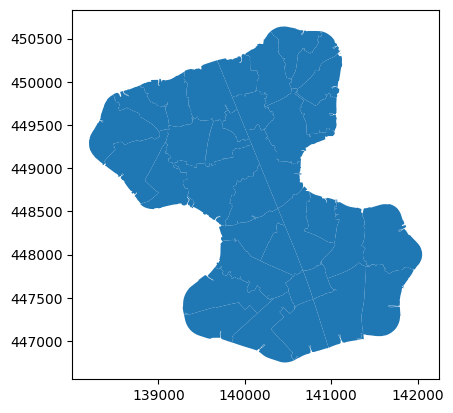

In [96]:
##### CREATE MAP #####
file_path = '../data/buurt_2020_v3.shp'
buurten_map = gpd.read_file(file_path)

gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

if clean_up:
    drop_buurten_houten = ['Buitengebied Houten West',
        'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
        "Buitengebied 't Goy", "'t Waal", 'Tull',
        "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
        'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
        'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
        'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
        'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
        'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

    drop_buurten_utrecht = [
        'Bedrijventerrein Lageweide',
        'Haarzuilens en omgeving',
        'Bedrijventerrein en omgeving',
        'Utrecht Science Park',
                'Bedrijvengebied Strijkviertel', 
                'Bedrijvengebied Papendorp',
                'Rijnenburg',
                'Poldergebied Overvecht' ,
                ]

    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]

gem_map.plot()

# plt.savefig('plots/gem_map.png')

####  RUN MODEL

In [113]:
buurten = pd.read_csv('../data/buurten.csv', index_col=0)
buurten = buurten.loc[buurten['gm_naam'].isin(gemeente_selectie)]
buurten = buurten.reset_index(drop=True)

In [114]:
### CHECK FOR WHICH BUURTEN WE DO NOT HAVE ENOUGH DATA
buurten = buurten.dropna()  #for now we just drop them
buurt_id = buurten[['buurt_code', 'regio']]
buurten = buurten.drop(['gm_naam', 'regio'], axis=1)

#create x and y var
y_id_buurten = pd.DataFrame(buurten['buurt_code'])
X = buurten[buurten.columns[~buurten.columns.isin(y.columns)]]


De volgende buurten zijn aan te raden: ['Campen', 'Gilden', 'Meren']


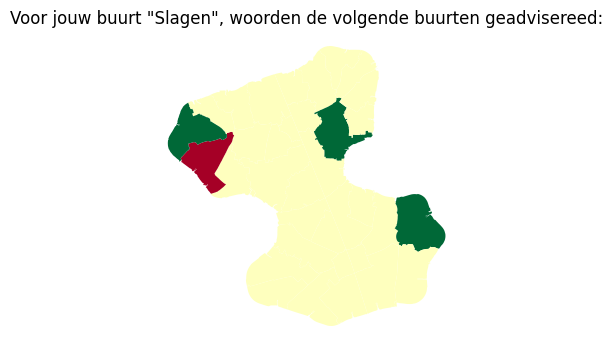

In [109]:
# create similarities between features in the dataframe
cosine_sim_matrix = cosine_similarity(X, X)

# zet naam om naar id van de buurt
code_van_buurt = buurt_id.loc[buurt_id['regio'] == buurt, 'buurt_code'].item()

# get all buurt-codes in de dataset en de indices die daarbij horen
buurten_code = buurten['buurt_code']
indice_per_buurtcode = pd.Series(buurten.index, index=buurten['buurt_code']) 

# create dataframe with predictions
indice_voor_selected_buurtcode = indice_per_buurtcode[code_van_buurt]

# get score voor sim_score
sim_scores_per_andere_buurt = list(enumerate(cosine_sim_matrix[indice_voor_selected_buurtcode]))
sim_scores_per_andere_buurt = sorted(sim_scores_per_andere_buurt, key=lambda x: x[1], reverse=True)
sim_scores_top_n = sim_scores_per_andere_buurt[1:n_predictions+1]  # without own similarity

# get scores as seperate list
scores = [i[1] for i in sim_scores_top_n]
scores = [round(score, 4) for score in scores]

# get names of the buurten that are recommended
buurten_indices = [i[0] for i in sim_scores_top_n]
recommendations = buurten.iloc[buurten_indices]['buurt_code'].to_list()
recommendations_df = pd.DataFrame(list(zip(recommendations, scores)))
recommendations_naam = buurt_id.loc[buurt_id['buurt_code'].isin(recommendations), 'regio'].to_list()

# create plot with predictions
merged_df = gem_map.merge(recommendations_df, left_on='BU_CODE', right_on=0, how='left')
merged_df.loc[~merged_df[1].isnull(),'dummy'] = 1           # green
merged_df.loc[merged_df[1].isnull(),'dummy'] = 0.5          # yellow
merged_df.loc[merged_df['BU_NAAM'] == buurt, 'dummy'] = 0   # red

# Maak een thematische kaart
p = merged_df.plot(column="dummy",
                    figsize = (6,4),
                    cmap='RdYlGn')
p.axis('off')
p.set_title(f'Voor jouw buurt "{buurt}", woorden de volgende buurten geadvisereed:')
print('De volgende buurten zijn aan te raden:', recommendations_naam)

In [110]:
### RENAME COLUMNS TO READABLE FORMAT
features_visualisatie = [ 'geometry', 'regio',
# 'buurt_code', 
'aantal_inwoners', 
'aantal_inwoners_tussen_25_44_percentage', 
'gemiddelde_huishoudensgrootte',
'woningvoorraad', 
'gemiddelde_woningwaarde', 
'meergezinswoning_percentage', 
'bewoond_percentage',
'koopwoning_percentage', 
'bouwjaar_vanaf_2000_percentage', 
# 'afstand_tot_grote_supermarkt_km', 
# 'afstand_tot_park_of_plantsoen_km', 
# 'afstand_tot_hoofdverkeersweg_km',
# 'afstand_tot_treinstation_km',
# 'leefbarometer_score', 
# 'aardgasverbruik_m3_gemiddeld', 
# 'elektriciteitsverbruik_kwh_gemiddeld',
# 'social_economische_score_gemiddeld', 
# 'geluid_van_treinverkeer',
# 'geluid_van_weg'
]

In [112]:
geometry = gem_map[['geometry', 'BU_CODE']]
geometry = geometry.merge(buurt_id, left_on='BU_CODE', right_on='buurt_code')
explore = geometry.merge(buurten, left_on='BU_CODE', right_on='buurt_code', how='left')
recommendations_plus_buurt = recommendations 
recommendations_plus_buurt.append(code_van_buurt)

explore = explore.loc[explore['BU_CODE'].isin(recommendations_plus_buurt)]
explore = explore[explore.columns[explore.columns.isin(features_visualisatie)]]
explore_interaction = explore.explore(popup=True)

# and then we write the map to disk
explore_interaction.save('recommendations_map.html')

# then open it
webbrowser.open('file://' + os.path.realpath('recommendations_map.html'))

True